# Chapter 18: Graph Neural Networks & Molecular Modeling

This chapter explores the transition from grid-based data to graph-structured data. The focus is on how to represent complex relationships, specifically in the context of **Quantum Chemistry** using the QM9 dataset.

---

## 📊 1. QM9 Dataset Representation
The **QM9 dataset** is the centerpiece of this chapter's practical application. It consists of approximately 130,000 small organic molecules. In a GNN, each molecule is represented as a unique graph structure.

### A. Node Features (Atoms)
Each node in the graph represents an atom. In your implementation, each node is described by an **11-dimensional feature vector**. These features typically include:
* Atomic number (e.g., Carbon, Nitrogen, Oxygen).
* Aromaticity status.
* The number of hydrogen atoms attached.
* Hybridization state.

### B. Edge Index & Attributes (Bonds)
The relationships between atoms (bonds) are represented by two specific tensors:
* **Edge Index:** A coordinate list defining which nodes are connected (e.g., node 0 is connected to node 1).
* **Edge Attributes:** A **4-dimensional feature vector** for every bond. This describes the bond type, such as:
    * Single bond.
    * Double bond.
    * Triple bond.
    * Aromatic bond.

### C. Global Targets (Chemical Properties)
Each graph (molecule) is associated with **19 regression targets**. These are quantum chemical properties calculated at a high level of theory, such as:
* Dipole moment.
* Isotropic polarizability.
* Highest occupied molecular orbital (HOMO) energy.


---

## 📩 2. The Message Passing Framework
The notebooks demonstrate how information flows across the graph through "Message Passing."

1.  **Aggregation:** For any given atom, the GNN gathers the feature vectors of all neighboring atoms. 
2.  **Edge Conditioning:** In the QM9 implementation, the **`NNConv`** (Neural Network Convolution) layer is used. It ensures that the "message" sent from one atom to another is transformed based on the **Edge Attribute** (the bond type) between them.
3.  **Update:** The atom updates its own internal state by combining its current features with the aggregated messages from its neighbors.


---

## 🏗️ 3. Architecture for Molecular Prediction
The model architecture in your notebook follows a specific pipeline to turn a graph into a single property prediction:

* **Convolutional Layers:** Multiple layers of `NNConv` are used to allow atoms to "learn" about their local and extended chemical environments.
* **Global Add Pooling (Readout):** Since we want to predict a property for the *whole* molecule, not just individual atoms, the model sums all the final atom embeddings together. This creates a fixed-size vector (a "molecular fingerprint").
* **Regression Head:** A series of fully connected layers takes this fingerprint and outputs a single scalar value representing the predicted chemical property.

---

## 📦 4. Structural Foundations (Simple GNN)
Before the complex QM9 tasks, the chapter establishes basic graph math:
* **Adjacency Matrix:** A binary matrix representing connectivity.
* **Self-Loops:** Adding an identity matrix to the adjacency matrix so nodes "remember" their own features during updates.
* **Normalization:** Scaling the adjacency matrix by the node degrees to maintain stable gradient flow during training.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

In [12]:
ds = QM9('.')
len(ds)

130831

In [13]:
data = ds[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [14]:
data.z

tensor([6, 1, 1, 1, 1])

In [15]:
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [16]:
device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu'
)
data.to(device)
data.new_attribute.is_cuda

True

In [21]:
class ExampleNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features*32)
        )
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16)
        )

        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, data):
        batch, x, edge_index, edge_attr = (
            data.batch, data.x, data.edge_index, data.edge_attr
        )
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        output = self.out(x)

        return output

In [22]:
train_set, valid_set, test_set = random_split(
    ds, [110000, 10831, 10000]
)
trainloader = DataLoader(train_set, batch_size= 32, shuffle= True)
validloader = DataLoader(valid_set, batch_size= 32, shuffle= False)
testloader = DataLoader(test_set, batch_size= 32, shuffle= False)

In [23]:
qm9_node_feats, qm9_edge_feats = 11, 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)
optimizer = torch.optim.Adam(
    net.parameters(), lr= 0.01
)
epochs = 4
target_idx = 1
device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu'
)
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [24]:
for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(
            output, batch.y[:, target_idx].unsqueeze(1)
        )
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()

    train_avg_loss = epoch_loss / total_graphs

    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(
            output, batch.y[:, target_idx].unsqueeze(1)
        )
        val_loss += loss.item()
        total_graphs += batch.num_graphs

    val_avg_loss = val_loss / total_graphs
    print(f"Epoch {total_epochs} | "
          f"Epoch Avg. Loss: {train_avg_loss:.3f} | "
          f"Validation Avg. Loss: {val_avg_loss:.3f}")

Epoch 0 | Epoch Avg. Loss: 0.346 | Validation Avg. Loss: 0.231
Epoch 1 | Epoch Avg. Loss: 0.122 | Validation Avg. Loss: 0.232
Epoch 2 | Epoch Avg. Loss: 0.100 | Validation Avg. Loss: 0.065
Epoch 3 | Epoch Avg. Loss: 0.088 | Validation Avg. Loss: 0.056


In [25]:
net.eval()
predictions, real = [], []
for batch in testloader:
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(
        batch.y[:, target_idx].detach().cpu().numpy()
    )

real = np.concatenate(real)
predictions = np.concatenate(predictions)

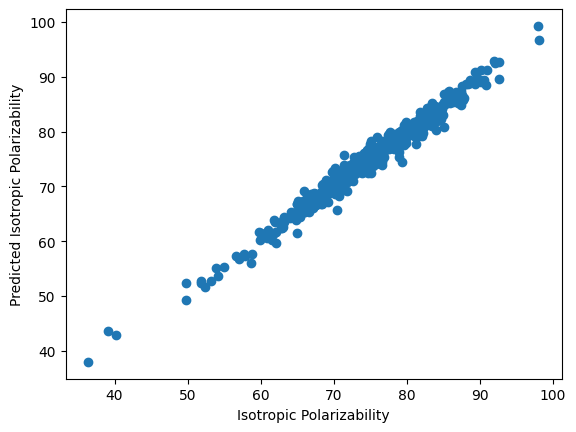

In [27]:
plt.scatter(real[:500], predictions[:500])
plt.xlabel('Isotropic Polarizability')
plt.ylabel('Predicted Isotropic Polarizability')
plt.show()